<a href="https://colab.research.google.com/github/jake314jake/ChessFENDeepLearningPrediction/blob/main/ChessFENAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jakeamberson","key":"1695b811524bfe70d51bb55701d14ece"}'}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                        480KB  2023-01-04 12:50:31           3724        136  1.0              
senapatirajesh/netflix-tv-shows-and-movies                      Latest Netflix TV shows and movies                  1MB  2023-01-14 17:03:12            691         21  0.88235295       
thedevastator/global-fossil-co2-emissions-by-country-2002-2022  Emissions by Country, 2002-2022                   621KB  2023-01-02 20:10:36           1856         63  1.0              
johnny1994/divorce-rates-data-should-you-get-married            Divorc

In [9]:
!kaggle datasets download -d koryakinp/chess-positions

100% 4.01G/4.01G [03:17<00:00, 24.7MB/s]
100% 4.01G/4.01G [03:17<00:00, 21.8MB/s]


In [10]:
!unzip chess-positions.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/b1K5-6rB-5k2-5r2-1b6-8-5n2-8.jpeg  
  inflating: train/b1K5-8-3k4-3p4-8-3B1r2-1b6-4N3.jpeg  
  inflating: train/b1K5-8-8-2p3p1-5k2-8-8-7R.jpeg  
  inflating: train/b1K5-8-8-8-2qr1N2-8-6nk-3b4.jpeg  
  inflating: train/b1K5-r7-4kb2-R4Q1p-b7-1pb5-5P2-8.jpeg  
  inflating: train/b1KB4-2B5-3p4-1BB5-3k1n2-p1r5-2n5-5r1q.jpeg  
  inflating: train/b1Kb4-6P1-n2Q3k-8-4N1n1-2b2P2-8-8.jpeg  
  inflating: train/b1Kr4-8-q7-8-1bB5-8-2k1P1RR-8.jpeg  
  inflating: train/b1Kr4-P7-R2R4-1b3B2-3Pr3-4Nk2-8-4R3.jpeg  
  inflating: train/b1N1k3-K1q5-1P1B4-2R5-3N3Q-3brP2-8-1B1n4.jpeg  
  inflating: train/b1N1n1q1-R5RQ-1N2r2P-3n4-3k4-8-3n3N-K7.jpeg  
  inflating: train/b1N1qn2-1P5k-b3K1p1-8-2B4n-7N-5B2-1b2B3.jpeg  
  inflating: train/b1N1r1k1-2R5-1r2b3-5KpR-N1P5-8-6R1-7B.jpeg  
  inflating: train/b1N1r3-2P1r1k1-3b4-8-3K3b-2rB4-7p-8.jpeg  
  inflating: train/b1N2K1b-2Bp4-4B2k-b2p4-8-7n-3p3n-2B2B2.jpeg  
  inflating: train/b1N2b1R-3n4-P2P4-1n2K

# DATASET
DATA------> image

LABEL----->fen description
## training 
5000 imges 
## testing
1500 imges (~30%)
## validation
500 imges (~10%)

In [55]:
train_size = 5000
test_size = 1500 #30/100
val_size=500     #10/100
train = glob.glob("/content/train/*.jpeg")
test = glob.glob("/content/test/*.jpeg")
shuffle(train)
shuffle(test)

train = train[:train_size]
test = test[:test_size]
val = train[-val_size:]
print(len(train))
print(len(test))
print(len(val))
piece_symbols = 'prbnkqPRBNKQ'


5000
1500
500


Text(0.5, 1.0, 'Average height: 400.0')

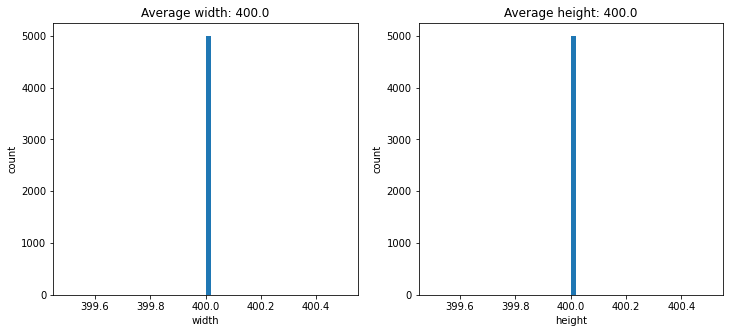

In [56]:
import cv2
widths = []
heights = []

for img in train:
  img= cv2.imread(img)
  heights.append(img.shape[0])
  widths.append(img.shape[1])

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))


ax1.hist(widths, bins=50)
ax1.set_xlabel('width')
ax1.set_ylabel('count')
ax1.set_title('Average width: {}'.format(np.mean(widths)))

ax2.hist(heights, bins=50)
ax2.set_xlabel('height')
ax2.set_ylabel('count')
ax2.set_title('Average height: {}'.format(np.mean(heights)))



In [57]:
def fen_from_filename(image):
  base = os.path.basename(image)
  return os.path.splitext(base)[0]

# extract fen (label) from image

In [54]:
imageOne=train[0]
imageTwo=test[0]
print(fen_from_filename(imageOne))
print(fen_from_filename(imageTwo))

5b1q-6P1-8-2PK1kp1-NR6-4Q3-b2r4-1R1B2n1
2KR4-R7-4P2N-2k5-2b5-8-8-8


# get the pairs (image,FEN)

(-0.5, 399.5, 399.5, -0.5)

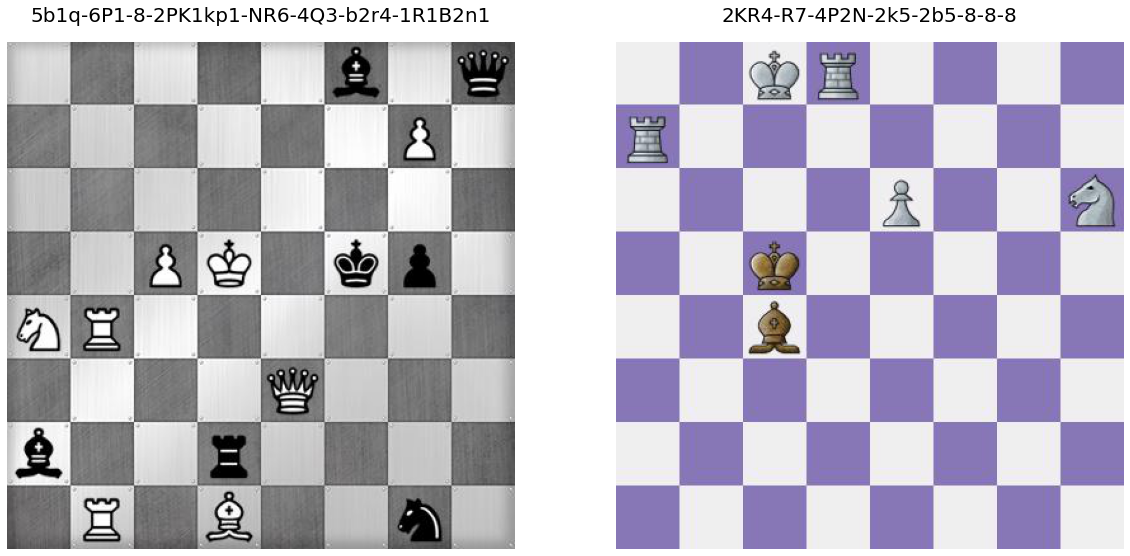

In [15]:
f, axarr = plt.subplots(1,2, figsize=(20, 30))


axarr[0].set_title(fen_from_filename(train[0]), fontsize=20, pad=20)
axarr[0].imshow(mpimg.imread(train[0]))
axarr[0].axis('off')

axarr[1].set_title(fen_from_filename(test[0]), fontsize=20, pad=20)
axarr[1].imshow(mpimg.imread(test[0]))
axarr[1].axis('off')



# OneHot format 
is our model output

array of 64*13

each row is chess square

each column is a chess piece -------> prbnkqPRBNKQ and Empty square also!

 (in a binary format )

In [58]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [59]:
print(onehot_from_fen(fen_from_filename(train[0])).shape)
print(onehot_from_fen(fen_from_filename(train[0])))




(64, 13)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.

# process image
resize image to 200*200

normalize the image

and reshape the image (each row is a square 25*25)

In [60]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read=img_read/255.0
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

In [61]:
process_image(train[0]).shape

(64, 25, 25, 3)

# generate an input
>> data,label 

In [62]:
def Input_gen(features):
    for i, img in enumerate(features):
        data = process_image(img)
        label = onehot_from_fen(fen_from_filename(img))
        
        yield data, label


In [76]:
img_rows = 25
img_cols = 25

# Setup hyper parameters for deep learning

EPOCHS = 10
BATCH_SIZE = 32
NB_CLASSES = 13


In [77]:
model = Sequential()

In [78]:
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

In [79]:
# Add a convolutional layer
model.add(Convolution2D(15, kernel_size=2, activation='relu', 
                 input_shape=(img_rows, img_cols, 3)))


# Add a pooling operation
model.add(MaxPool2D(2))

# Add another convolutional layer
model.add(Convolution2D(5, kernel_size=2, activation='relu'))

# Flatten and feed to output layer
model.add(Flatten())
# Add a dropout layer
model.add(Dropout(0.3))
model.add(Dense(int(len(piece_symbols)+1), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 15)        195       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 15)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 5)         305       
                                                                 
 flatten_2 (Flatten)         (None, 605)               0         
                                                                 
 dropout_2 (Dropout)         (None, 605)               0         
                                                                 
 dense_2 (Dense)             (None, 13)                7878      
                                                      

In [80]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


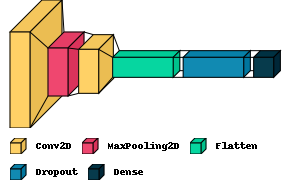

In [70]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [81]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [82]:
model.fit(Input_gen(train), 
          batch_size = BATCH_SIZE, 
          epochs = EPOCHS,
          validation_data=Input_gen(val),
          steps_per_epoch=train_size//BATCH_SIZE,
          validation_steps=val_size//BATCH_SIZE)

Epoch 1/10
156/156 [==============================] - 4s 25ms/step - loss: 0.8570 - accuracy: 0.8339 - val_loss: 0.6921 - val_accuracy: 0.8354
Epoch 2/10
156/156 [==============================] - 6s 39ms/step - loss: 0.4815 - accuracy: 0.8675 - val_loss: 0.3434 - val_accuracy: 0.9052
Epoch 3/10
156/156 [==============================] - 7s 43ms/step - loss: 0.2826 - accuracy: 0.9245 - val_loss: 0.1303 - val_accuracy: 0.9479
Epoch 4/10
156/156 [==============================] - 6s 41ms/step - loss: 0.1727 - accuracy: 0.9559 - val_loss: 0.2472 - val_accuracy: 0.9312
Epoch 5/10
156/156 [==============================] - 6s 39ms/step - loss: 0.1175 - accuracy: 0.9696 - val_loss: 0.1083 - val_accuracy: 0.9729
Epoch 6/10
156/156 [==============================] - 4s 23ms/step - loss: 0.1020 - accuracy: 0.9744 - val_loss: 0.0468 - val_accuracy: 0.9958
Epoch 7/10
156/156 [==============================] - 4s 24ms/step - loss: 0.0825 - accuracy: 0.9797 - val_loss: 0.0472 - val_accuracy: 0.9896

In [83]:
res = (
  model.predict_generator(Input_gen(test), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)
res.shape


(1500, 8, 8)

In [84]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()
print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.71800%


In [85]:

print([i for i, (x, y) in enumerate(zip(pred_fens, test_fens)) if x != y])

[4, 5, 8, 18, 25, 33, 35, 37, 43, 48, 51, 53, 55, 56, 66, 71, 85, 86, 87, 89, 90, 92, 95, 101, 110, 112, 115, 117, 120, 125, 131, 132, 133, 145, 154, 156, 158, 166, 169, 179, 181, 186, 191, 193, 197, 200, 202, 219, 220, 224, 227, 235, 243, 245, 249, 252, 253, 254, 259, 260, 261, 281, 285, 286, 287, 290, 293, 300, 302, 303, 304, 307, 311, 316, 317, 323, 324, 325, 331, 332, 334, 336, 350, 356, 376, 381, 394, 401, 405, 406, 412, 413, 418, 419, 420, 429, 430, 432, 437, 439, 447, 452, 459, 463, 465, 468, 469, 474, 477, 479, 482, 485, 486, 490, 494, 497, 499, 501, 503, 504, 507, 509, 513, 517, 523, 524, 525, 538, 539, 540, 546, 547, 548, 550, 552, 553, 555, 563, 567, 572, 573, 576, 578, 582, 587, 591, 592, 593, 598, 604, 605, 606, 615, 616, 619, 621, 626, 628, 629, 636, 637, 642, 644, 651, 652, 653, 654, 658, 662, 663, 666, 671, 676, 682, 686, 688, 694, 699, 706, 708, 710, 715, 716, 718, 720, 721, 722, 723, 728, 730, 731, 735, 740, 743, 751, 753, 755, 759, 760, 770, 773, 774, 775, 778, 781, 

In [86]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

2/2 [==============================] - 0s 7ms/step


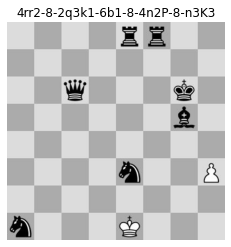

4rr2-8-2q3k1-6b1-8-4n2P-8-n3K3
2/2 [==============================] - 0s 7ms/step


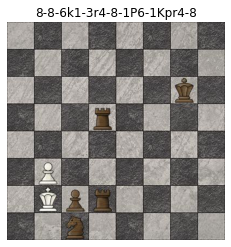

8-8-6k1-3r4-8-1P6-1Kpr4-2n5


In [87]:
#correct predection
display_with_predicted_fen(test[0])
print(fen_from_filename(test[0]))
#wrong predection
display_with_predicted_fen(test[4])
print(fen_from_filename(test[4]))
